In [ ]:
import numpy as np
import h5py
import tensorflow as tf
from tensorflow.keras.saving import register_keras_serializable

def normalize_events(events):    
    return events / events.max()

# Normalize truths independently
def normalize_truths(truths):
    truths_max = truths.max(axis=(1, 2, 3), keepdims=True)
    return truths / truths_max


# Load data
with h5py.File('/home/filippo/DUNE/data/numu-CC-QE/lightweight_dataset_20cm.h5', 'r') as f:
    events = f['inputs'][:]    # Load all inputs into memory
    truths = f['targets'][:]   # Load all targets into memory

# ----------------------------
# 1. Normalize inputs to [0, 1]
# ----------------------------
normalized_events = normalize_events(events)
normalized_truths = normalize_truths(truths)
# Inputs: (N, 60)
X = normalized_events

# Targets: (N, 2, 4, 5) with values in [0, 1]
y = normalized_truths

# ---- Build the model ----
input_dim = 60
#output_shape = (2, 4, 5)  #30cm
output_shape = (3, 6, 7)  #20cm
#output_shape = (4, 8, 9)  #15cm

@register_keras_serializable()
class MaxNormalize1D(tf.keras.layers.Layer):
    def call(self, inputs):
        max_val = tf.reduce_max(inputs, axis=1, keepdims=True)
        return inputs / (max_val + 1e-6)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_dim,)),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(64, activation='relu'),

    tf.keras.layers.Dense(np.prod(output_shape), activation='relu'),
    
    MaxNormalize1D(),

    tf.keras.layers.Reshape(output_shape)
])


model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()

# ---- Train the model ----

history = model.fit(X, y, epochs=50, batch_size=32, validation_split=0.3)

# Save the trained model to a file
model.save('/home/filippo/DUNE/pre-volumereco/saved_models/pre_volumereco_20cm.keras')

2025-06-11 16:31:33.540070: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-11 16:31:33.963258: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749652294.123755     882 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749652294.179782     882 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-11 16:31:34.580777: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 126)            │         8,190 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_normalize1d                 │ (None, 126)            │             0 │
│ (MaxNormalize1D)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 3, 6, 7)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,790 (163.24 KB)

 Trainable params: 41,278 (161.24 KB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/50


I0000 00:00:1749652305.880111   24426 service.cc:148] XLA service 0x7f5bf4006cc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749652305.880511   24426 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-06-11 16:31:45.961902: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1749652306.306552   24426 cuda_dnn.cc:529] Loaded cuDNN version 90300


16/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0683 - mae: 0.1380

I0000 00:00:1749652309.820972   24426 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0487 - mae: 0.0962

2025-06-11 16:31:52.575697: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_70', 8 bytes spill stores, 8 bytes spill loads



63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - loss: 0.0484 - mae: 0.0957 - val_loss: 0.0219 - val_mae: 0.0315
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0222 - mae: 0.0344 - val_loss: 0.0211 - val_mae: 0.0304
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0205 - mae: 0.0311 - val_loss: 0.0202 - val_mae: 0.0300
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0198 - mae: 0.0302 - val_loss: 0.0197 - val_mae: 0.0297
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0194 - mae: 0.0295 - val_loss: 0.0194 - val_mae: 0.0293
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0190 - mae: 0.0292 - val_loss: 0.0195 - val_mae: 0.0301
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0189 - mae: 0.0290 - val_loss: 0.0192 - val_mae: 0.0298
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0187 - mae: 0.0287 - val_loss: 0.0194 - val_mae: 0.0299
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0184 - mae: 0.02

In [4]:
import numpy as np
import h5py
import tensorflow as tf
from tensorflow.keras.saving import register_keras_serializable
import optuna
from optuna.integration import TFKerasPruningCallback
from sklearn.model_selection import train_test_split

# ---- Data Preprocessing ----

def normalize_events(events):    
    return events / events.max()

def normalize_truths(truths):
    truths_max = truths.max(axis=(1, 2, 3), keepdims=True)
    return truths / truths_max

with h5py.File('/home/filippo/DUNE/data/numu-CC-QE/lightweight_dataset_20cm.h5', 'r') as f:
    events = f['inputs'][:]
    truths = f['targets'][:]

X = normalize_events(events)
y = normalize_truths(truths)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

input_dim = 60
output_shape = (3, 6, 7)

@register_keras_serializable()
class MaxNormalize1D(tf.keras.layers.Layer):
    def call(self, inputs):
        max_val = tf.reduce_max(inputs, axis=1, keepdims=True)
        return inputs / (max_val + 1e-6)

# ---- Objective Function ----

def objective(trial):
    optimizer_name = trial.suggest_categorical("optimizer", ["adam", "sgd", "rmsprop"])
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    # Fixed units
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),

        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate),

        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate),

        tf.keras.layers.Dense(64, activation='relu'),

        tf.keras.layers.Dense(np.prod(output_shape), activation='relu'),
        MaxNormalize1D(),
        tf.keras.layers.Reshape(output_shape)
    ])

    # Select optimizer
    if optimizer_name == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    elif optimizer_name == "rmsprop":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=batch_size,
        verbose=0,
        callbacks=[TFKerasPruningCallback(trial, "val_loss")]
    )

    return min(history.history["val_loss"])

# ---- Run Optuna Study ----

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

# ---- Best Trial ----

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2025-07-07 17:43:22,221] A new study created in memory with name: no-name-be78e01f-3d1b-45ba-a2b4-d25a54167968
I0000 00:00:1751903005.526873   42853 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
I0000 00:00:1751903008.423738   43978 service.cc:148] XLA service 0x7f46640033d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751903008.425114   43978 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-07-07 17:43:28.519814: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1751903008.737483   43978 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1751903012.605403   43978 device_compiler.h:188] C

Best trial:
  Value: 0.012945382855832577
  Params:
    optimizer: rmsprop
    learning_rate: 0.004734777276024365
    dropout_rate: 0.19084617485484645
    batch_size: 32


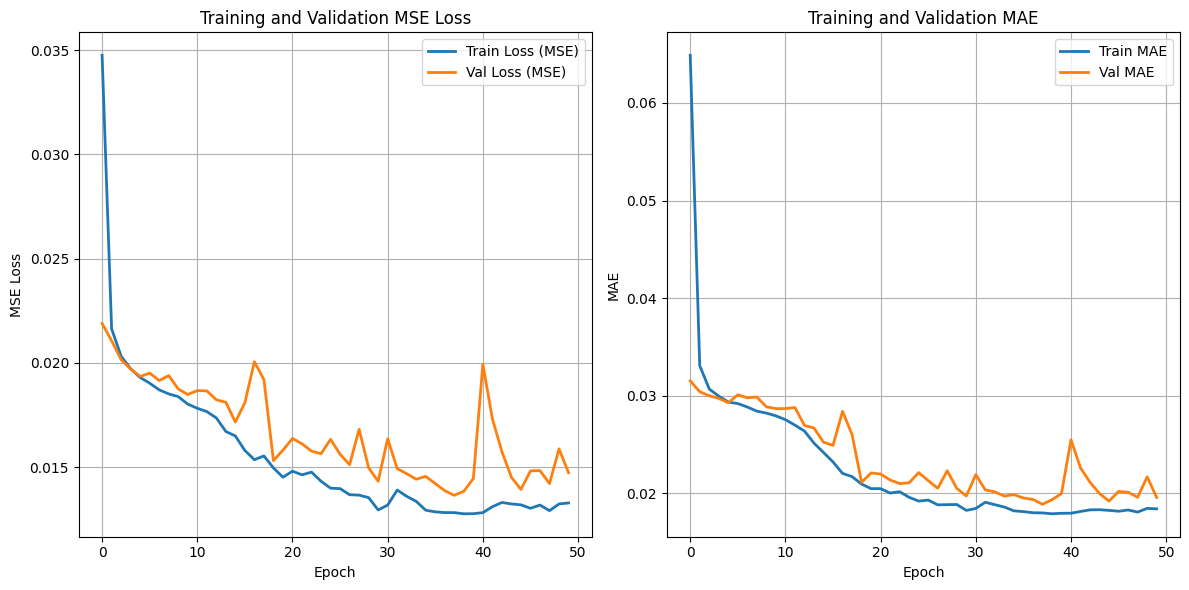

In [2]:
import matplotlib.pyplot as plt

# ---- Plot loss and MAE curves ----

plt.figure(figsize=(12, 6))

# Plot MSE Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss (MSE)', lw=2)
plt.plot(history.history['val_loss'], label='Val Loss (MSE)', lw=2)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation MSE Loss')
plt.legend()
plt.grid(True)

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE', lw=2)
plt.plot(history.history['val_mae'], label='Val MAE', lw=2)
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


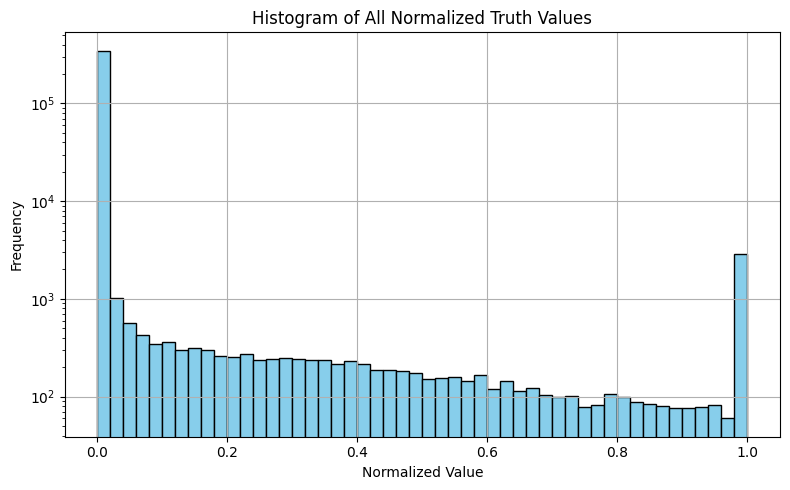

In [3]:
# Flatten all values in normalized_truths into a 1D array
all_values = normalized_truths.flatten()

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(all_values, bins=50, color='skyblue', edgecolor='black', log=True)
plt.xlabel('Normalized Value')
plt.ylabel('Frequency')
plt.title('Histogram of All Normalized Truth Values')
plt.grid(True)
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
(1, 60) [[0.9775096  0.9800102  0.9679655  0.96778685 0.95805794 0.95966303
  0.9455607  0.9339739  0.9074271  0.9270369  0.9116116  0.92292476
  0.92581195 0.94694686 0.92483854 0.95742565 0.95973015 0.9640512
  0.9759186  0.9786644  0.90531546 0.9196883  0.9268071  0.92503124
  0.91938525 0.9289322  0.9611923  0.9467419  0.95662314 0.89315015
  0.83846503 0.7294951  0.9600251  0.9520008  0.96191686 0.98403025
  0.97947526 0.01269886 0.31724662 0.8252304  0.6382357  0.3577846
  0.6263434  0.9133837  0.89407164 0.92517453 0.30294293 0.9829347
  0.9746894  0.9771419  0.934481   0.96069664 0.8105124  0.9227285
  0.6936343  0.31559885 0.26403    0.01000806 0.21022943 0.06479034]]


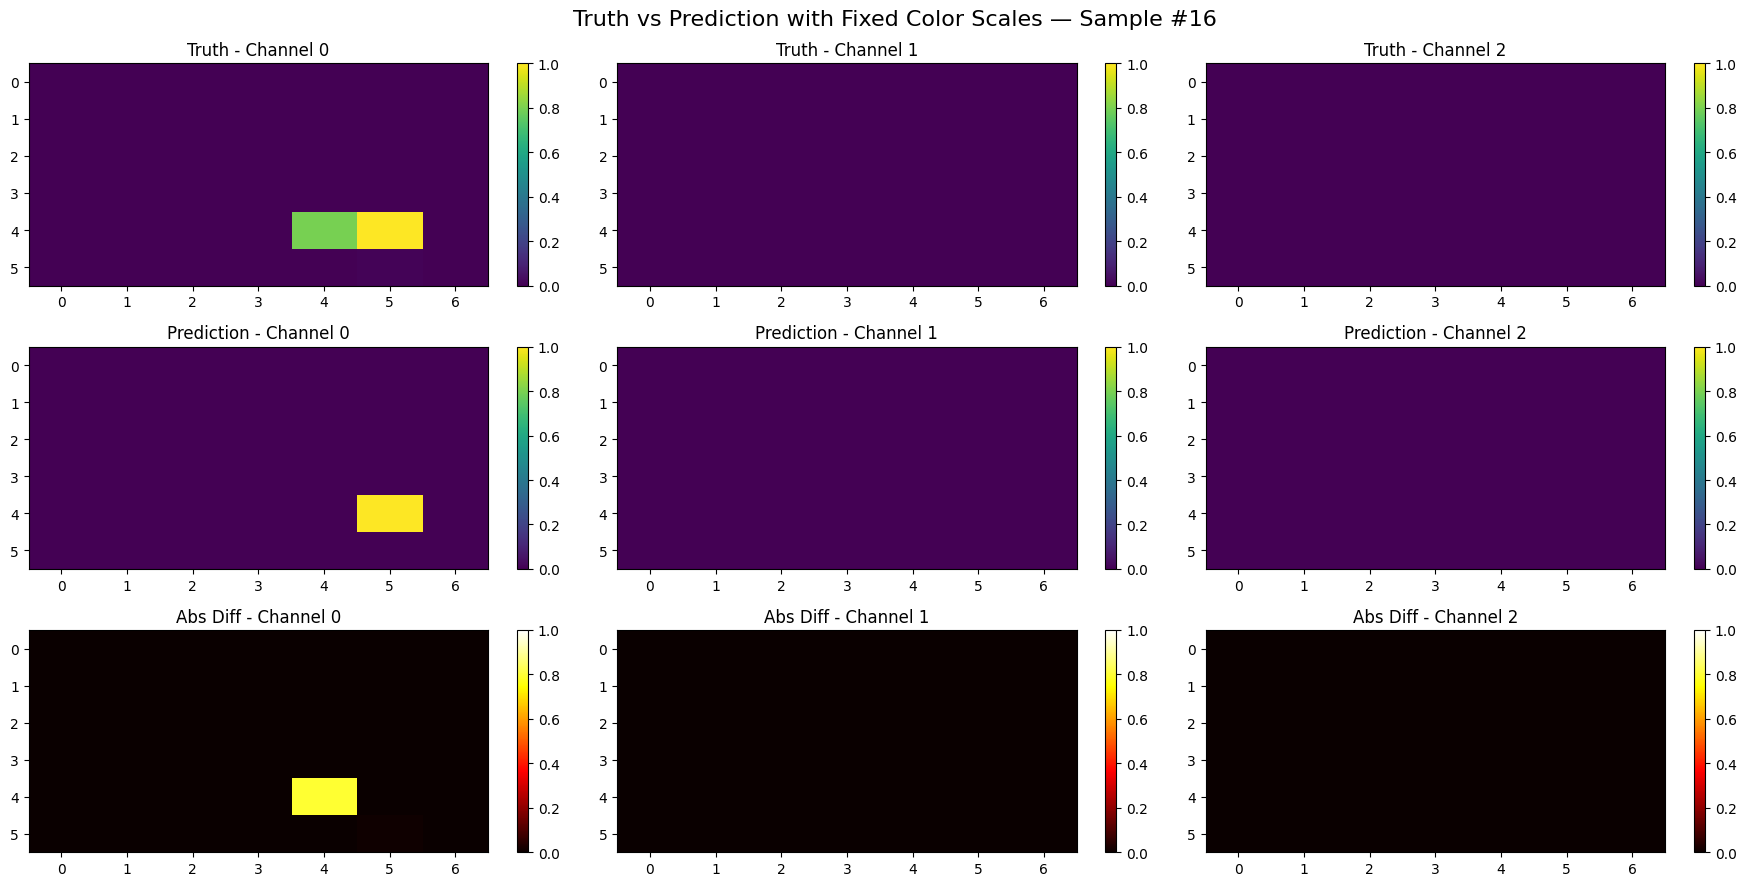

In [8]:
from tensorflow.keras.models import load_model

# Load the previously saved model
model = load_model(
    "/home/filippo/DUNE/pre-volumereco/saved_models/pre_volumereco_20cm.keras",
    custom_objects={"MaxNormalize1D": MaxNormalize1D},
    compile=True,
)

def plot_truth_vs_pred(truth, pred, sample_idx=0):
    fig, axes = plt.subplots(3, truth.shape[0], figsize=(18, 9))

    for i in range(truth.shape[0]):
        # Truth (fixed scale 0–1)
        im0 = axes[0, i].imshow(truth[i], cmap='viridis', aspect='auto', vmin=0, vmax=1)
        axes[0, i].set_title(f'Truth - Channel {i}')
        plt.colorbar(im0, ax=axes[0, i])

        # Prediction (fixed scale 0–1)
        im1 = axes[1, i].imshow(pred[i], cmap='viridis', aspect='auto', vmin=0, vmax=1)
        axes[1, i].set_title(f'Prediction - Channel {i}')
        plt.colorbar(im1, ax=axes[1, i])

        # Absolute Difference (fixed scale 0–1, or tweak if needed)
        im2 = axes[2, i].imshow(np.abs(truth[i] - pred[i]), cmap='hot', aspect='auto', vmin=0, vmax=1)
        axes[2, i].set_title(f'Abs Diff - Channel {i}')
        plt.colorbar(im2, ax=axes[2, i])

    plt.suptitle(f'Truth vs Prediction with Fixed Color Scales — Sample #{sample_idx}', fontsize=16)
    plt.tight_layout()
    plt.show()

# Get one prediction
sample_idx = 16
truth_sample = y[sample_idx]                                 
predicted = model.predict(X[sample_idx:sample_idx+1])[0]
print(X[sample_idx:sample_idx+1].shape, X[sample_idx:sample_idx+1])
plot_truth_vs_pred(y[sample_idx], predicted, sample_idx)

(27, 67, 69)


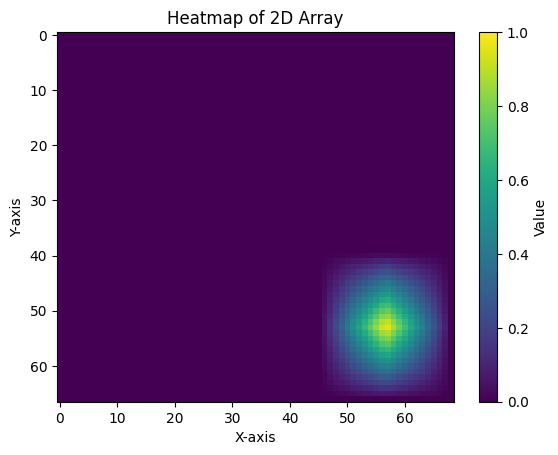

In [22]:
from scipy.ndimage import zoom

# Original array of shape (3, 6, 7)
expected_shape = (27, 67, 69)
zoom_factors = (expected_shape[0]/predicted.shape[0],expected_shape[1]/predicted.shape[1],expected_shape[2]/predicted.shape[2])  # Non-integer factors are fine
new_array = zoom(predicted, zoom_factors, order=1)
print(new_array.shape)

plt.imshow(new_array[0], cmap='viridis', aspect='auto', vmin=0, vmax=1)
plt.colorbar(label='Value')  # adds a color scale legend
plt.title('Heatmap of 2D Array')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

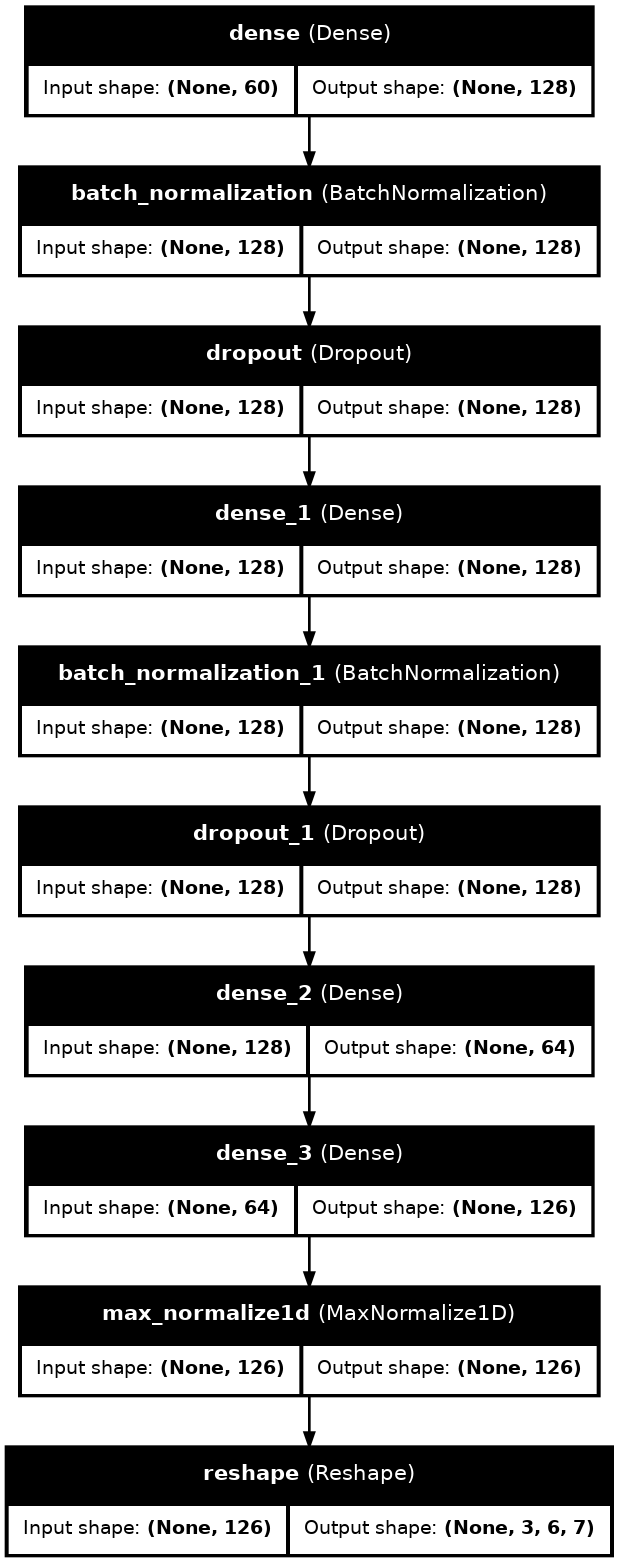

In [5]:
from tensorflow.keras.utils import plot_model

plot_model(
    model,
    #to_file="model_architecture.png",
    show_shapes=True,
    show_layer_names=True,
    dpi=96
)
